In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import numpy as np
from utils import *

In [2]:
PER_UNIT_GDP = 'Per unit GDP'
ROAD_DENSITY = 'Road density'
POPULATION_DENSITY = 'Population density'
ELEVATION = 'Elevation'
SLOPE = 'Slope'
RAINFALL_FREQUENCY = 'Rainfall frequency'
RIVER_DENSITY = 'River density'
RAINFALL_AMOUNT = 'Rainfall amount'
FLOOD = 'Flood'

In [3]:
# population density
# popolazione 

In [4]:
values_dictionary = {
    PER_UNIT_GDP: [
        [0.3], 
        [0.63], 
        [0.07]
    ],
    POPULATION_DENSITY: [
        [0.7, 0.3, 0.05],
        [0.2, 0.55, 0.25],
        [0.1, 0.15, 0.7],
    ],
    ROAD_DENSITY: [
        [0.8, 0.7, 0.1, 0.6, 0.4, 0.1, 0.1, 0.05, 0.01],
        [0.19, 0.25, 0.35, 0.3, 0.5, 0.25, 0.25, 0.2, 0.15],
        [0.01, 0.05, 0.55, 0.1, 0.1, 0.65, 0.65, 0.75, 0.84]
    ],
    ELEVATION: [
        [0.15],
        [0.1], 
        [0.75]
    ],
    SLOPE: [
        [0.75, 0.6, 0.05], 
        [0.25, 0.4, 0.95]
    ],
    RAINFALL_FREQUENCY: [
        [0.3], 
        [0.6], 
        [0.1]
    ],
    RIVER_DENSITY: [
        [0.4], 
        [0.6]
    ],
    RAINFALL_AMOUNT: [
        [0.7, 0.5, 0.55, 0.3, 0.1, 0.01],
        [0.2, 0.25, 0.3, 0.4, 0.3, 0.04],
        [0.1, 0.25, 0.15, 0.3, 0.6, 0.95]
    ],
    FLOOD: [
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
    ],
}

# FLOOD, ROAD_DENSITY, SLOPE, RAINFALL_AMOUNT

In [5]:
table_dictionary = {
    PER_UNIT_GDP: ['High', 'Medium', 'Low'],
    ROAD_DENSITY: ['Dense', 'Medium', 'Sparse'],
    POPULATION_DENSITY: ['Dense', 'Medium', 'Sparse'],
    ELEVATION: ['High', 'Medium', 'Low'],
    SLOPE: ['Steep', 'Flat'],
    RAINFALL_FREQUENCY: ['Frequent', 'Medium', 'Rare'],
    RIVER_DENSITY: ['Dense', 'Sparse'],
    RAINFALL_AMOUNT: ['Huge', 'Medium', 'Little'],
    FLOOD: ['Yes', 'No']
}

In [6]:
edges = [
    (PER_UNIT_GDP, ROAD_DENSITY), 
    (PER_UNIT_GDP, POPULATION_DENSITY), 
    (POPULATION_DENSITY, ROAD_DENSITY),
    (ROAD_DENSITY, FLOOD),
    (ELEVATION, SLOPE),
    (SLOPE, FLOOD),
    (RAINFALL_FREQUENCY, RAINFALL_AMOUNT),
    (RIVER_DENSITY, RAINFALL_AMOUNT),
    (RAINFALL_AMOUNT, FLOOD)
]

In [7]:
# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel(edges)

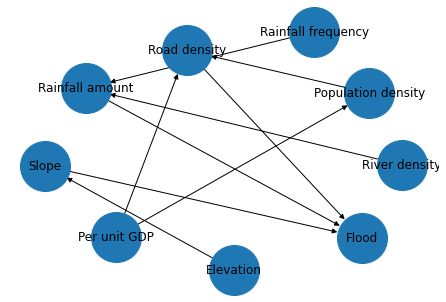

In [8]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
nx.draw(model, node_size=2500, with_labels=True)
plt.show()

In [9]:
# ToDo: an idea can be to set the evidence, its cardinality and the state_names programmatically, 
# or even define these tables in a for loop

cpd_per_unit_gdp = TabularCPD(
    variable = PER_UNIT_GDP, 
    variable_card = len(table_dictionary[PER_UNIT_GDP]), 
    values = values_dictionary[PER_UNIT_GDP],
    state_names= pick_dictionary_subset(table_dictionary, [PER_UNIT_GDP])
)


cpd_population_density = TabularCPD(
    variable = POPULATION_DENSITY, 
    variable_card = len(table_dictionary[POPULATION_DENSITY]), 
    values = values_dictionary[POPULATION_DENSITY],
    evidence=[PER_UNIT_GDP],
    evidence_card=[len(table_dictionary[PER_UNIT_GDP])],
    state_names= pick_dictionary_subset(
        table_dictionary, [POPULATION_DENSITY, PER_UNIT_GDP]
    )
)

cpd_road_density = TabularCPD(
    variable = ROAD_DENSITY, 
    variable_card = len(table_dictionary[ROAD_DENSITY]), 
    values = values_dictionary[ROAD_DENSITY],
    evidence=[PER_UNIT_GDP, POPULATION_DENSITY],
    evidence_card=[len(table_dictionary[PER_UNIT_GDP]), len(table_dictionary[POPULATION_DENSITY])],
    state_names= pick_dictionary_subset(
        table_dictionary, [ROAD_DENSITY, PER_UNIT_GDP, POPULATION_DENSITY]
    )
)

cpd_rainfall_amount = TabularCPD(
    variable = RAINFALL_AMOUNT, 
    variable_card = len(table_dictionary[RAINFALL_AMOUNT]), 
    values = values_dictionary[RAINFALL_AMOUNT],
    evidence = [RAINFALL_FREQUENCY, RIVER_DENSITY],
    evidence_card=[len(table_dictionary[RAINFALL_FREQUENCY]), len(table_dictionary[RIVER_DENSITY])],
    state_names= pick_dictionary_subset(
        table_dictionary, [RAINFALL_AMOUNT, RAINFALL_FREQUENCY, RIVER_DENSITY]
    )
)

cpd_flood = TabularCPD(
    variable = FLOOD, 
    variable_card = len(table_dictionary[FLOOD]), 
    values = values_dictionary[FLOOD],
    evidence = [ROAD_DENSITY, SLOPE, RAINFALL_AMOUNT],
    evidence_card=[len(table_dictionary[ROAD_DENSITY]), len(table_dictionary[SLOPE]), len(table_dictionary[RAINFALL_AMOUNT]),],
    state_names= pick_dictionary_subset(
        table_dictionary, [FLOOD, ROAD_DENSITY, SLOPE, RAINFALL_AMOUNT]
    )
)

In [10]:
#print(cpd_road_density)

+----------------------+---------------------------+----------------------------+----------------------------+---------------------------+----------------------------+----------------------------+---------------------------+----------------------------+----------------------------+
| Per unit GDP         | Per unit GDP(High)        | Per unit GDP(High)         | Per unit GDP(High)         | Per unit GDP(Medium)      | Per unit GDP(Medium)       | Per unit GDP(Medium)       | Per unit GDP(Low)         | Per unit GDP(Low)          | Per unit GDP(Low)          |
+----------------------+---------------------------+----------------------------+----------------------------+---------------------------+----------------------------+----------------------------+---------------------------+----------------------------+----------------------------+
| Population density   | Population density(Dense) | Population density(Medium) | Population density(Sparse) | Population density(Dense) | Population d

In [11]:
pcd_to_pandas(cpd_road_density)

Per unit GDP(High)          \
                        Population density(Dense)    
 Road density(Dense)                          0.80   
 Road density(Medium)                         0.19   
 Road density(Sparse)                         0.01   

                        Per unit GDP(High)           \
                        Population density(Medium)    
 Road density(Dense)                           0.70   
 Road density(Medium)                          0.25   
 Road density(Sparse)                          0.05   

                                                     \
                        Population density(Sparse)    
 Road density(Dense)                           0.10   
 Road density(Medium)                          0.35   
 Road density(Sparse)                          0.55   

                        Per unit GDP(Medium)        \
                        Population density(Dense)    
 Road density(Dense)                           0.6   
 Road density(Medium)                          0.3   
 Road density(Sparse)                          0.1   

                        Per unit GDP(Medium)         \
                        Population density(Medium)    
 Road density(Dense)                            0.4   
 Road density(Medium)                           0.5   
 Road density(Sparse)                           0.1   

                                                     \
                        Population density(Sparse)    
 Road density(Dense)                           0.10   
 Road density(Medium)                          0.25   
 Road density(Sparse)                          0.65   

                        Per unit GDP(Low)           \
                        Population density(Dense)    
 Road density(Dense)                          0.10   
 Road density(Medium)                         0.25   
 Road density(Sparse)                         0.65   

                        Per unit GDP(Low)            \
                        Population density(Medium)    
 Road density(Dense)                           0.05   
 Road density(Medium)                          0.20   
 Road density(Sparse)                          0.75   

                                                     
                        Population density(Sparse)   
 Road density(Dense)                           0.01  
 Road density(Medium)                          0.15  
 Road density(Sparse)                          0.84

In [12]:
pcd_to_pandas(cpd_flood)

Road density(Dense)     Road density(Dense)       \
                   Slope(Steep)            Slope(Steep)               
                   Rainfall amount(Huge)   Rainfall amount(Medium)    
 Flood(Yes)                           0.1                       0.1   
 Flood(No)                            0.2                       0.2   

                                             Road density(Dense)     \
                                             Slope(Flat)              
                   Rainfall amount(Little)   Rainfall amount(Huge)    
 Flood(Yes)                             0.1                     0.1   
 Flood(No)                              0.2                     0.2   

                   Road density(Dense)                                 \
                   Slope(Flat)                                          
                   Rainfall amount(Medium)   Rainfall amount(Little)    
 Flood(Yes)                             0.1                       0.1   
 Flood(No)                              0.2                       0.2   

                   Road density(Medium)    Road density(Medium)      \
                   Slope(Steep)            Slope(Steep)               
                   Rainfall amount(Huge)   Rainfall amount(Medium)    
 Flood(Yes)                           0.1                       0.1   
 Flood(No)                            0.2                       0.2   

                                             Road density(Medium)    \
                                             Slope(Flat)              
                   Rainfall amount(Little)   Rainfall amount(Huge)    
 Flood(Yes)                             0.1                     0.1   
 Flood(No)                              0.2                     0.2   

                   Road density(Medium)                                \
                   Slope(Flat)                                          
                   Rainfall amount(Medium)   Rainfall amount(Little)    
 Flood(Yes)                             0.1                       0.1   
 Flood(No)                              0.2                       0.2   

                   Road density(Sparse)    Road density(Sparse)      \
                   Slope(Steep)            Slope(Steep)               
                   Rainfall amount(Huge)   Rainfall amount(Medium)    
 Flood(Yes)                           0.1                       0.1   
 Flood(No)                            0.2                       0.2   

                                             Road density(Sparse)    \
                                             Slope(Flat)              
                   Rainfall amount(Little)   Rainfall amount(Huge)    
 Flood(Yes)                             0.1                     0.1   
 Flood(No)                              0.2                     0.2   

                   Road density(Sparse)                                
                   Slope(Flat)                                         
                   Rainfall amount(Medium)   Rainfall amount(Little)   
 Flood(Yes)                             0.1                       0.1  
 Flood(No)                              0.2                       0.2